In [1]:
# Install libraries for data_loader
!pip install pandas
!pip install sklearn
#!pip install albumentations
!pip install torchvision
!pip install tqdm
!pip install torchmetrics

In [2]:
# Import DataLoader and corresponding libraries
import pandas
import torchvision.transforms as TT
# import albumentations as T
# import albumentations.augmentations.transforms as T_transforms
# from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader, Dataset, sampler
from sklearn.model_selection import StratifiedKFold
from torchvision import utils
from PIL import Image

In [3]:
# Import libraries for tensors
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# For fbeta-score
from torchmetrics.functional import fbeta_score

# For nn.Sequential
from collections import OrderedDict

In [4]:
# Import tqdm for progress bar construction
import tqdm

In [5]:
# Datatypes and Devices (from Assignment 2)
dtype = torch.float
ltype = torch.long

if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda:0


In [6]:
# Hyper-parameters for K-Fold Cross Validation
N = 5
seed = 42

# from google.colab import drive
# drive.mount('/content/gdrive')


# Directories for Data
FF1010_Path = './data/'
AudioImage_Path = './image/'

In [7]:
# Call StratifiedKFold object
skf = StratifiedKFold(
    n_splits=5, shuffle=True, random_state=seed
)

In [8]:
# Modify dataframe for K-Fold Cross Validation (ff1010)
ff1010_csv = pandas.read_csv(FF1010_Path + 'metadata.csv')
ff1010_csv.loc[ff1010_csv['hasbird'] == 0, 'filepath'] = \
    FF1010_Path + 'nocall/' + ff1010_csv.query('hasbird == 0')['filename'] + '.npy'
ff1010_csv.loc[ff1010_csv['hasbird'] == 1, 'filepath'] = \
    FF1010_Path + 'bird/' + ff1010_csv.query('hasbird == 1')['filename'] + '.npy'

ff1010_csv = ff1010_csv.dropna()
ff1010_csv = ff1010_csv.reset_index(drop=True)

# Add 'fold' attribute for dataset classification
ff1010_dataframe = ff1010_csv.copy()
for n, (_, nth_groups) in enumerate(
    skf.split(ff1010_dataframe, ff1010_dataframe['hasbird'])):
    ff1010_dataframe.loc[nth_groups, 'fold'] = int(n)

Model 1 (No-call detector)

In [9]:
# Set the seed for consistency
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [10]:
# Class for ff1010 dataset
class FF1010(Dataset):
    def __init__(self, dataframe, process='train', labels='hasbird'):
        self.dataframe = dataframe
        self.filepaths = dataframe['filepath'].values
        self.labels = dataframe[labels].values
        self.process = process
        
        # Transforms for each train and validation
        self.train_transform = TT.Compose([
            TT.Resize([128, 281]),
            TT.RandomHorizontalFlip(p=0.5),
            TT.RandomVerticalFlip(p=0.5),
#             T_transforms.ImageCompression(p=0.5, 
#                 compression_type=T_transforms.ImageCompression.ImageCompressionType.JPEG),
#             T_transforms.ImageCompression(p=0.5, 
#                 compression_type=T_transforms.ImageCompression.ImageCompressionType.WEBP),
            TT.ToTensor(),
            TT.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
        ])
        self.val_transform = TT.Compose([
            TT.Resize([128, 281]),
            TT.ToTensor(),
            TT.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
        ])
    
    def __getitem__(self, idx):
        source = np.load(self.filepaths[idx])
        
        # Rearrange numpy arrays
        source = source.transpose(1, 2, 0)
        # Add RGB dimension
        source = np.stack((np.squeeze(source), ) * 3, -1)
        
        # Apply transform
        if self.process == 'train':
            source = self.train_transform(Image.fromarray(source))
        elif self.process == 'valid':
            source = self.val_transform(Image.fromarray(source))
        
        return source, torch.tensor(self.labels[idx], dtype=ltype).to(device)
    
    def __len__(self):
        return len(self.dataframe)

This function evaluates model.

In [11]:
def evaluate_model(loader, model, beta):
    print("Checking accuracy score on validation set.")
    # TODO: extend this so that we can print that we evaluate test set.
    num_correct = 0
    num_samples = 0
    log_sum = 0
    fbeta_sum = 0
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=torch.float)
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            # scores means classfication class for each class. It should be the tensor with size of (Input size, Number of classes)
            # In binary classification, it should be (batch size, 2) sized tensor

            # Checks naive accuracy.
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)

            # Checks Log Loss.
            log_loss = F.nll_loss(F.log_softmax(scores, dim=-1), y)
            log_sum += log_loss.sum() * preds.size(0)

            # Checks Fbeta-score.
            fbeta = fbeta_score(preds, y, beta=beta)
            fbeta_sum += fbeta * preds.size(0)

        acc = float(num_correct) / num_samples
        log_score = log_sum / num_samples
        f_score = fbeta_sum / num_samples
        print('\nAccuracy: %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
        print('Log Loss score:\t%.2f' % (log_score))
        print('Fbeta-score (beta=%d): \t%.2f' % (beta , f_score))
    return acc, log_score, f_score

Let's train with model 1.

In [12]:
# Print period for accuracy.
print_period = 12

# Hyper-parameters for training 
ff1010_batch = 32
ff1010_epoch = 10

# Learning Rate.
learning_rate_1 = 0.001

# L2 Regularization Hyperparamter
weight_decay_1 = 0.001

# Beta constant for Fbeta-score.
# If you want to give more weight to precision, use value smaller than 1.0.
# If you want to give more weight to recall, use value larger than 1.0.
beta = 1.0

# Prototype of model 1.
# ResNet50 outputs (Batchsize, 1000) tensor as output, so we reduce them to 2.
# TODO: I'm curious about the output of the model: would output be the float number
#       between 0 and 1? If not, we need to add sigmoid or softmax function at the end.
model_1 = nn.Sequential(OrderedDict([
        ("resnet50", torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True).to(device)),
        ("relu", nn.ReLU().to(device)),
        ("linear", nn.Linear(1000, 2, bias=True).to(device)),
        ("softmax", nn.Softmax(dim=-1))
]))

print(model_1)

def train_model(model, train_loader, val_loader, optimizer, beta=beta, epoch=ff1010_epoch):
    val_losses = []
    train_losses = []
    epoch_losses = []
    log_scores = []
    fbeta_scores = []
    
    loss = 0
    log_score = 0
    for e in range(epoch):
        print(f"Training model 1, epoch {e+1}")
        for index, (source, label) in enumerate(tqdm.tqdm(train_loader)):
            x = source.to(device=device, dtype=torch.float)  # move to device, e.g. GPU
            y = label.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.nll_loss(F.log_softmax(scores, dim=-1), y) # Log loss for our project.
            epoch_losses.append(loss)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # every print_period, evaluate on val_loader.
            if index % print_period == 0:
                print('Iteration %d, loss = %.4f' % (index, loss.item()))
        acc, log_score, fbeta_score = evaluate_model(val_loader, model, beta=beta)
        val_losses.append(acc)
        epoch_losses = [t.double() for t in epoch_losses]
        train_losses.append(torch.tensor(sum(epoch_losses) / len(epoch_losses), dtype=dtype))
        log_scores.append(log_score)
        fbeta_scores.append(fbeta_score)

    return model, val_losses, train_losses, log_scores, fbeta_scores

Using cache found in C:\Users\youngrae/.cache\torch\hub\pytorch_vision_v0.10.0


Sequential(
  (resnet50): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [13]:
# from time import sleep

# Train loop for nocall detector
def nocall_train(model, train_dataframe, val_dataframe, test_dataframe):  
    train_data = FF1010(train_dataframe, process='train', labels='hasbird')
    val_data = FF1010(val_dataframe, process='valid', labels='hasbird')
    test_data = FF1010(test_dataframe, process='valid', labels='hasbird')
    
    # Construct data loader for train and validation
    train_loader = DataLoader(train_data, batch_size=ff1010_batch,
                             sampler=sampler.SubsetRandomSampler(range(len(train_dataframe))), 
                             drop_last=True)
    val_loader = DataLoader(val_data, batch_size=ff1010_batch,
                             sampler=sampler.SubsetRandomSampler(range(len(val_dataframe))),
                             drop_last=False)
    test_loader = DataLoader(test_data, batch_size=ff1010_batch,
                              sampler=sampler.SubsetRandomSampler(range(len(test_dataframe))),
                              drop_last=False)
    
    # Test for loaders
    
    optimizer = optim.SGD(model.parameters(), lr=learning_rate_1, momentum=0.5, weight_decay=weight_decay_1)
#     optimizer = optim.Adam(model.parameters(), lr=learning_rate_1, weight_decay=weight_decay_1)
    trained_model, val_losses, train_losses, log_scores, fbeta_scores = train_model(
        model, train_loader, val_loader, optimizer, beta=beta)
    test_acc, test_log_score, test_fbeta_score = evaluate_model(test_loader, trained_model, beta=beta)
    
    return val_losses, train_losses, log_scores, fbeta_scores, [test_acc, test_log_score, test_fbeta_score]

In [14]:
# Train, Validate and Test for nocall detector
def nocall(model, dataframe, val_index, test_index):
    
    # Check that validation fold is not same as test fold
    assert val_index != test_index, \
        'Validation and test should be done on different fold.'
    print('Test set : %d, Validation set : %d' % (test_index, val_index))
    
    train_dataframe = dataframe.query(
        'fold != ' + str(val_index) + ' and fold != ' + str(test_index) 
    ).reset_index(drop=True)
    val_dataframe = dataframe.query(
        'fold == ' + str(val_index) 
    ).reset_index(drop=False)
    test_dataframe = dataframe.query(
        'fold == ' + str(test_index) 
    ).reset_index(drop=False)
    
    val_losses, train_losses, log_scores, fbeta_scores, test_scores = nocall_train(
        model, train_dataframe, val_dataframe, test_dataframe)

    return val_losses, train_losses, log_scores, fbeta_scores, test_scores

In [15]:
cur_model = nn.Sequential(OrderedDict([
    ("resnet50", torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True).to(device)),
    ("relu", nn.ReLU().to(device)),
    ("linear", nn.Linear(1000, 2, bias=True).to(device)),
    ("softmax", nn.Softmax(dim=-1))
]))
val_losses, train_losses, log_scores, fbeta_scores, test_scores = nocall(cur_model, ff1010_dataframe, 1, 0)

for i in range(2, 5):
    cur_model = nn.Sequential(OrderedDict([
        ("resnet50", torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True).to(device)),
        ("relu", nn.ReLU().to(device)),
        ("linear", nn.Linear(1000, 2, bias=True).to(device)),
        ("softmax", nn.Softmax(dim=-1))
    ]))
    cv_losses, ctr_losses, cl_scores, cf_scores, cte_scores = nocall(cur_model, ff1010_dataframe, i, 0)
    val_losses = torch.mean(torch.stack((torch.tensor(val_losses), torch.tensor(cv_losses))), dim=0)
    train_losses = torch.mean(torch.stack((torch.tensor(train_losses), torch.tensor(ctr_losses))), dim=0)
    log_scores = torch.mean(torch.stack((torch.tensor(log_scores), torch.tensor(cl_scores))), dim=0)
    fbeta_scores = torch.mean(torch.stack((torch.tensor(fbeta_scores), torch.tensor(cf_scores))), dim=0)
    for j in range(len(test_scores)):
        test_scores[j] = torch.mean(torch.stack((torch.tensor(test_scores[j]), torch.tensor(cte_scores[j]))), dim=0)

Using cache found in C:\Users\youngrae/.cache\torch\hub\pytorch_vision_v0.10.0


Test set : 0, Validation set : 1
Training model 1, epoch 1


  1%|▌                                                                                 | 1/144 [00:03<07:37,  3.20s/it]

Iteration 0, loss = 0.6671


  9%|███████▎                                                                         | 13/144 [00:06<00:51,  2.56it/s]

Iteration 12, loss = 0.5521


 17%|██████████████                                                                   | 25/144 [00:10<00:44,  2.67it/s]

Iteration 24, loss = 0.5403


 26%|████████████████████▊                                                            | 37/144 [00:14<00:40,  2.67it/s]

Iteration 36, loss = 0.5257


 34%|███████████████████████████▌                                                     | 49/144 [00:17<00:35,  2.66it/s]

Iteration 48, loss = 0.4986


 42%|██████████████████████████████████▎                                              | 61/144 [00:21<00:31,  2.66it/s]

Iteration 60, loss = 0.5073


 51%|█████████████████████████████████████████                                        | 73/144 [00:25<00:26,  2.67it/s]

Iteration 72, loss = 0.4816


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:28<00:22,  2.67it/s]

Iteration 84, loss = 0.5405


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:32<00:17,  2.66it/s]

Iteration 96, loss = 0.5799


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:36<00:13,  2.66it/s]

Iteration 108, loss = 0.4881


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:39<00:08,  2.66it/s]

Iteration 120, loss = 0.4737


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:43<00:04,  2.66it/s]

Iteration 132, loss = 0.4574


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:46<00:00,  3.10it/s]


Checking accuracy score on validation set.


C:\Users\youngrae\AppData\Local\Temp/ipykernel_2876/9450484.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_losses.append(torch.tensor(sum(epoch_losses) / len(epoch_losses), dtype=dtype))



Accuracy: 1275 / 1538 correct (82.90)
Log Loss score:	0.49
Fbeta-score (beta=1): 	0.83
Training model 1, epoch 2


  1%|▌                                                                                 | 1/144 [00:00<00:43,  3.26it/s]

Iteration 0, loss = 0.5064


  9%|███████▎                                                                         | 13/144 [00:03<00:48,  2.69it/s]

Iteration 12, loss = 0.4054


 17%|██████████████                                                                   | 25/144 [00:07<00:44,  2.70it/s]

Iteration 24, loss = 0.5134


 26%|████████████████████▊                                                            | 37/144 [00:11<00:39,  2.69it/s]

Iteration 36, loss = 0.4728


 34%|███████████████████████████▌                                                     | 49/144 [00:14<00:35,  2.69it/s]

Iteration 48, loss = 0.4828


 42%|██████████████████████████████████▎                                              | 61/144 [00:18<00:30,  2.70it/s]

Iteration 60, loss = 0.4639


 51%|█████████████████████████████████████████                                        | 73/144 [00:21<00:26,  2.69it/s]

Iteration 72, loss = 0.4288


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:25<00:21,  2.69it/s]

Iteration 84, loss = 0.3920


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:29<00:17,  2.69it/s]

Iteration 96, loss = 0.4389


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:32<00:13,  2.69it/s]

Iteration 108, loss = 0.5059


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:36<00:08,  2.67it/s]

Iteration 120, loss = 0.4443


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:40<00:04,  2.70it/s]

Iteration 132, loss = 0.5772


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:43<00:00,  3.34it/s]


Checking accuracy score on validation set.

Accuracy: 1316 / 1538 correct (85.57)
Log Loss score:	0.45
Fbeta-score (beta=1): 	0.86
Training model 1, epoch 3


  1%|▌                                                                                 | 1/144 [00:00<00:43,  3.27it/s]

Iteration 0, loss = 0.3960


  9%|███████▎                                                                         | 13/144 [00:03<00:48,  2.69it/s]

Iteration 12, loss = 0.4553


 17%|██████████████                                                                   | 25/144 [00:07<00:44,  2.69it/s]

Iteration 24, loss = 0.4558


 26%|████████████████████▊                                                            | 37/144 [00:11<00:39,  2.69it/s]

Iteration 36, loss = 0.4697


 34%|███████████████████████████▌                                                     | 49/144 [00:14<00:35,  2.69it/s]

Iteration 48, loss = 0.5281


 42%|██████████████████████████████████▎                                              | 61/144 [00:18<00:30,  2.69it/s]

Iteration 60, loss = 0.5101


 51%|█████████████████████████████████████████                                        | 73/144 [00:21<00:26,  2.69it/s]

Iteration 72, loss = 0.4923


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:25<00:21,  2.68it/s]

Iteration 84, loss = 0.3985


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:29<00:17,  2.68it/s]

Iteration 96, loss = 0.3844


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:32<00:13,  2.68it/s]

Iteration 108, loss = 0.4662


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:36<00:08,  2.68it/s]

Iteration 120, loss = 0.4295


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:40<00:04,  2.69it/s]

Iteration 132, loss = 0.4962


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:43<00:00,  3.34it/s]


Checking accuracy score on validation set.

Accuracy: 1331 / 1538 correct (86.54)
Log Loss score:	0.44
Fbeta-score (beta=1): 	0.87
Training model 1, epoch 4


  1%|▌                                                                                 | 1/144 [00:00<00:44,  3.23it/s]

Iteration 0, loss = 0.4581


  9%|███████▎                                                                         | 13/144 [00:03<00:48,  2.68it/s]

Iteration 12, loss = 0.4692


 17%|██████████████                                                                   | 25/144 [00:07<00:44,  2.68it/s]

Iteration 24, loss = 0.3760


 26%|████████████████████▊                                                            | 37/144 [00:11<00:39,  2.69it/s]

Iteration 36, loss = 0.4225


 34%|███████████████████████████▌                                                     | 49/144 [00:14<00:35,  2.68it/s]

Iteration 48, loss = 0.5404


 42%|██████████████████████████████████▎                                              | 61/144 [00:18<00:30,  2.69it/s]

Iteration 60, loss = 0.4225


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:26,  2.68it/s]

Iteration 72, loss = 0.5407


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:25<00:22,  2.67it/s]

Iteration 84, loss = 0.4927


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:29<00:17,  2.67it/s]

Iteration 96, loss = 0.3762


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:32<00:13,  2.67it/s]

Iteration 108, loss = 0.4419


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:36<00:08,  2.69it/s]

Iteration 120, loss = 0.4945


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:40<00:04,  2.67it/s]

Iteration 132, loss = 0.4486


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:43<00:00,  3.32it/s]


Checking accuracy score on validation set.

Accuracy: 1355 / 1538 correct (88.10)
Log Loss score:	0.43
Fbeta-score (beta=1): 	0.88
Training model 1, epoch 5


  1%|▌                                                                                 | 1/144 [00:00<00:44,  3.21it/s]

Iteration 0, loss = 0.4728


  9%|███████▎                                                                         | 13/144 [00:03<00:49,  2.62it/s]

Iteration 12, loss = 0.4473


 17%|██████████████                                                                   | 25/144 [00:07<00:44,  2.67it/s]

Iteration 24, loss = 0.3480


 26%|████████████████████▊                                                            | 37/144 [00:11<00:39,  2.68it/s]

Iteration 36, loss = 0.4771


 34%|███████████████████████████▌                                                     | 49/144 [00:14<00:35,  2.67it/s]

Iteration 48, loss = 0.4983


 42%|██████████████████████████████████▎                                              | 61/144 [00:18<00:31,  2.66it/s]

Iteration 60, loss = 0.3595


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:27,  2.56it/s]

Iteration 72, loss = 0.4376


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:26<00:22,  2.67it/s]

Iteration 84, loss = 0.4157


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:29<00:17,  2.68it/s]

Iteration 96, loss = 0.4369


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:33<00:13,  2.67it/s]

Iteration 108, loss = 0.5017


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:36<00:08,  2.67it/s]

Iteration 120, loss = 0.4031


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:40<00:04,  2.67it/s]

Iteration 132, loss = 0.4590


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:43<00:00,  3.29it/s]


Checking accuracy score on validation set.

Accuracy: 1340 / 1538 correct (87.13)
Log Loss score:	0.44
Fbeta-score (beta=1): 	0.87
Training model 1, epoch 6


  1%|▌                                                                                 | 1/144 [00:00<00:44,  3.23it/s]

Iteration 0, loss = 0.3854


  9%|███████▎                                                                         | 13/144 [00:03<00:48,  2.68it/s]

Iteration 12, loss = 0.3254


 17%|██████████████                                                                   | 25/144 [00:07<00:44,  2.68it/s]

Iteration 24, loss = 0.5602


 26%|████████████████████▊                                                            | 37/144 [00:11<00:40,  2.67it/s]

Iteration 36, loss = 0.3820


 34%|███████████████████████████▌                                                     | 49/144 [00:14<00:35,  2.67it/s]

Iteration 48, loss = 0.5124


 42%|██████████████████████████████████▎                                              | 61/144 [00:18<00:31,  2.67it/s]

Iteration 60, loss = 0.4152


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:26,  2.66it/s]

Iteration 72, loss = 0.3447


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:25<00:22,  2.67it/s]

Iteration 84, loss = 0.4928


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:29<00:17,  2.68it/s]

Iteration 96, loss = 0.4417


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:33<00:13,  2.67it/s]

Iteration 108, loss = 0.4329


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:36<00:08,  2.66it/s]

Iteration 120, loss = 0.4918


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:40<00:04,  2.67it/s]

Iteration 132, loss = 0.4280


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:43<00:00,  3.31it/s]


Checking accuracy score on validation set.

Accuracy: 1358 / 1538 correct (88.30)
Log Loss score:	0.43
Fbeta-score (beta=1): 	0.88
Training model 1, epoch 7


  1%|▌                                                                                 | 1/144 [00:00<00:44,  3.23it/s]

Iteration 0, loss = 0.4130


  9%|███████▎                                                                         | 13/144 [00:03<00:48,  2.68it/s]

Iteration 12, loss = 0.4507


 17%|██████████████                                                                   | 25/144 [00:07<00:44,  2.68it/s]

Iteration 24, loss = 0.3782


 26%|████████████████████▊                                                            | 37/144 [00:11<00:40,  2.67it/s]

Iteration 36, loss = 0.4646


 34%|███████████████████████████▌                                                     | 49/144 [00:14<00:35,  2.66it/s]

Iteration 48, loss = 0.3885


 42%|██████████████████████████████████▎                                              | 61/144 [00:18<00:31,  2.67it/s]

Iteration 60, loss = 0.4111


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:26,  2.67it/s]

Iteration 72, loss = 0.3562


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:25<00:22,  2.68it/s]

Iteration 84, loss = 0.4242


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:29<00:17,  2.67it/s]

Iteration 96, loss = 0.3617


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:33<00:13,  2.66it/s]

Iteration 108, loss = 0.4759


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:36<00:08,  2.65it/s]

Iteration 120, loss = 0.3412


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:40<00:04,  2.67it/s]

Iteration 132, loss = 0.3791


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:43<00:00,  3.30it/s]


Checking accuracy score on validation set.

Accuracy: 1345 / 1538 correct (87.45)
Log Loss score:	0.44
Fbeta-score (beta=1): 	0.87
Training model 1, epoch 8


  1%|▌                                                                                 | 1/144 [00:00<00:44,  3.24it/s]

Iteration 0, loss = 0.4350


  9%|███████▎                                                                         | 13/144 [00:03<00:48,  2.68it/s]

Iteration 12, loss = 0.4395


 17%|██████████████                                                                   | 25/144 [00:07<00:44,  2.68it/s]

Iteration 24, loss = 0.4366


 26%|████████████████████▊                                                            | 37/144 [00:11<00:40,  2.66it/s]

Iteration 36, loss = 0.4115


 34%|███████████████████████████▌                                                     | 49/144 [00:14<00:35,  2.67it/s]

Iteration 48, loss = 0.5011


 42%|██████████████████████████████████▎                                              | 61/144 [00:18<00:31,  2.66it/s]

Iteration 60, loss = 0.3546


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:26,  2.66it/s]

Iteration 72, loss = 0.5665


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:25<00:22,  2.66it/s]

Iteration 84, loss = 0.3517


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:29<00:17,  2.65it/s]

Iteration 96, loss = 0.3774


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:33<00:13,  2.66it/s]

Iteration 108, loss = 0.4075


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:36<00:08,  2.66it/s]

Iteration 120, loss = 0.4296


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:40<00:04,  2.64it/s]

Iteration 132, loss = 0.4182


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:43<00:00,  3.30it/s]


Checking accuracy score on validation set.

Accuracy: 1357 / 1538 correct (88.23)
Log Loss score:	0.43
Fbeta-score (beta=1): 	0.88
Training model 1, epoch 9


  1%|▌                                                                                 | 1/144 [00:00<00:46,  3.09it/s]

Iteration 0, loss = 0.3904


  9%|███████▎                                                                         | 13/144 [00:04<00:53,  2.43it/s]

Iteration 12, loss = 0.3782


 17%|██████████████                                                                   | 25/144 [00:08<00:48,  2.47it/s]

Iteration 24, loss = 0.4121


 26%|████████████████████▊                                                            | 37/144 [00:12<00:40,  2.65it/s]

Iteration 36, loss = 0.3616


 34%|███████████████████████████▌                                                     | 49/144 [00:15<00:35,  2.66it/s]

Iteration 48, loss = 0.3747


 42%|██████████████████████████████████▎                                              | 61/144 [00:19<00:31,  2.61it/s]

Iteration 60, loss = 0.4795


 51%|█████████████████████████████████████████                                        | 73/144 [00:23<00:27,  2.59it/s]

Iteration 72, loss = 0.5322


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:26<00:22,  2.62it/s]

Iteration 84, loss = 0.5304


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:30<00:17,  2.65it/s]

Iteration 96, loss = 0.4109


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:34<00:13,  2.65it/s]

Iteration 108, loss = 0.3634


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:38<00:08,  2.66it/s]

Iteration 120, loss = 0.4789


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:41<00:04,  2.66it/s]

Iteration 132, loss = 0.3962


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:44<00:00,  3.21it/s]


Checking accuracy score on validation set.

Accuracy: 1358 / 1538 correct (88.30)
Log Loss score:	0.43
Fbeta-score (beta=1): 	0.88
Training model 1, epoch 10


  1%|▌                                                                                 | 1/144 [00:00<00:44,  3.19it/s]

Iteration 0, loss = 0.3672


  9%|███████▎                                                                         | 13/144 [00:03<00:49,  2.65it/s]

Iteration 12, loss = 0.5358


 17%|██████████████                                                                   | 25/144 [00:07<00:44,  2.65it/s]

Iteration 24, loss = 0.3436


 26%|████████████████████▊                                                            | 37/144 [00:11<00:40,  2.66it/s]

Iteration 36, loss = 0.3765


 34%|███████████████████████████▌                                                     | 49/144 [00:15<00:35,  2.65it/s]

Iteration 48, loss = 0.5012


 42%|██████████████████████████████████▎                                              | 61/144 [00:18<00:31,  2.65it/s]

Iteration 60, loss = 0.4892


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:26,  2.65it/s]

Iteration 72, loss = 0.4549


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:26<00:22,  2.65it/s]

Iteration 84, loss = 0.4767


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:29<00:17,  2.65it/s]

Iteration 96, loss = 0.3582


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:33<00:13,  2.66it/s]

Iteration 108, loss = 0.3818


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:37<00:08,  2.65it/s]

Iteration 120, loss = 0.3391


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:40<00:04,  2.64it/s]

Iteration 132, loss = 0.4112


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:43<00:00,  3.28it/s]


Checking accuracy score on validation set.

Accuracy: 1346 / 1538 correct (87.52)
Log Loss score:	0.44
Fbeta-score (beta=1): 	0.88
Checking accuracy score on validation set.

Accuracy: 1336 / 1538 correct (86.87)
Log Loss score:	0.44
Fbeta-score (beta=1): 	0.87


Using cache found in C:\Users\youngrae/.cache\torch\hub\pytorch_vision_v0.10.0


Test set : 0, Validation set : 2
Training model 1, epoch 1


  1%|▌                                                                                 | 1/144 [00:00<00:49,  2.87it/s]

Iteration 0, loss = 0.7075


  9%|███████▎                                                                         | 13/144 [00:04<00:49,  2.66it/s]

Iteration 12, loss = 0.5287


 17%|██████████████                                                                   | 25/144 [00:07<00:44,  2.66it/s]

Iteration 24, loss = 0.6484


 26%|████████████████████▊                                                            | 37/144 [00:11<00:40,  2.65it/s]

Iteration 36, loss = 0.5728


 34%|███████████████████████████▌                                                     | 49/144 [00:14<00:35,  2.66it/s]

Iteration 48, loss = 0.5636


 42%|██████████████████████████████████▎                                              | 61/144 [00:18<00:31,  2.66it/s]

Iteration 60, loss = 0.6144


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:26,  2.67it/s]

Iteration 72, loss = 0.5165


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:25<00:22,  2.66it/s]

Iteration 84, loss = 0.4931


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:29<00:17,  2.65it/s]

Iteration 96, loss = 0.4746


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:33<00:13,  2.65it/s]

Iteration 108, loss = 0.5800


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:36<00:08,  2.66it/s]

Iteration 120, loss = 0.4749


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:40<00:04,  2.65it/s]

Iteration 132, loss = 0.5849


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:43<00:00,  3.30it/s]


Checking accuracy score on validation set.

Accuracy: 1256 / 1538 correct (81.66)
Log Loss score:	0.50
Fbeta-score (beta=1): 	0.82
Training model 1, epoch 2


  1%|▌                                                                                 | 1/144 [00:00<00:45,  3.14it/s]

Iteration 0, loss = 0.4782


  9%|███████▎                                                                         | 13/144 [00:04<00:50,  2.61it/s]

Iteration 12, loss = 0.4148


 17%|██████████████                                                                   | 25/144 [00:07<00:44,  2.68it/s]

Iteration 24, loss = 0.3836


 26%|████████████████████▊                                                            | 37/144 [00:11<00:39,  2.69it/s]

Iteration 36, loss = 0.5911


 34%|███████████████████████████▌                                                     | 49/144 [00:14<00:35,  2.68it/s]

Iteration 48, loss = 0.4661


 42%|██████████████████████████████████▎                                              | 61/144 [00:18<00:30,  2.69it/s]

Iteration 60, loss = 0.4966


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:26,  2.69it/s]

Iteration 72, loss = 0.4178


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:25<00:21,  2.69it/s]

Iteration 84, loss = 0.3853


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:29<00:17,  2.65it/s]

Iteration 96, loss = 0.5201


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:32<00:13,  2.67it/s]

Iteration 108, loss = 0.3823


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:36<00:08,  2.64it/s]

Iteration 120, loss = 0.4883


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:40<00:04,  2.68it/s]

Iteration 132, loss = 0.4378


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:43<00:00,  3.31it/s]


Checking accuracy score on validation set.

Accuracy: 1298 / 1538 correct (84.40)
Log Loss score:	0.46
Fbeta-score (beta=1): 	0.84
Training model 1, epoch 3


  1%|▌                                                                                 | 1/144 [00:00<00:44,  3.25it/s]

Iteration 0, loss = 0.4586


  9%|███████▎                                                                         | 13/144 [00:03<00:48,  2.69it/s]

Iteration 12, loss = 0.4626


 17%|██████████████                                                                   | 25/144 [00:07<00:44,  2.68it/s]

Iteration 24, loss = 0.4446


 26%|████████████████████▊                                                            | 37/144 [00:11<00:39,  2.68it/s]

Iteration 36, loss = 0.5119


 34%|███████████████████████████▌                                                     | 49/144 [00:14<00:35,  2.68it/s]

Iteration 48, loss = 0.3895


 42%|██████████████████████████████████▎                                              | 61/144 [00:18<00:30,  2.69it/s]

Iteration 60, loss = 0.4470


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:26,  2.69it/s]

Iteration 72, loss = 0.5028


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:25<00:21,  2.68it/s]

Iteration 84, loss = 0.4073


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:29<00:17,  2.68it/s]

Iteration 96, loss = 0.3999


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:32<00:13,  2.68it/s]

Iteration 108, loss = 0.4297


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:36<00:08,  2.69it/s]

Iteration 120, loss = 0.4730


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:40<00:04,  2.68it/s]

Iteration 132, loss = 0.4900


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:43<00:00,  3.33it/s]


Checking accuracy score on validation set.

Accuracy: 1305 / 1538 correct (84.85)
Log Loss score:	0.46
Fbeta-score (beta=1): 	0.85
Training model 1, epoch 4


  1%|▌                                                                                 | 1/144 [00:00<00:44,  3.25it/s]

Iteration 0, loss = 0.3687


  9%|███████▎                                                                         | 13/144 [00:03<00:48,  2.68it/s]

Iteration 12, loss = 0.4035


 17%|██████████████                                                                   | 25/144 [00:07<00:44,  2.69it/s]

Iteration 24, loss = 0.4833


 26%|████████████████████▊                                                            | 37/144 [00:11<00:39,  2.68it/s]

Iteration 36, loss = 0.4463


 34%|███████████████████████████▌                                                     | 49/144 [00:14<00:35,  2.68it/s]

Iteration 48, loss = 0.3597


 42%|██████████████████████████████████▎                                              | 61/144 [00:18<00:30,  2.68it/s]

Iteration 60, loss = 0.4384


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:26,  2.68it/s]

Iteration 72, loss = 0.4587


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:25<00:22,  2.68it/s]

Iteration 84, loss = 0.4835


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:29<00:17,  2.69it/s]

Iteration 96, loss = 0.4321


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:32<00:13,  2.69it/s]

Iteration 108, loss = 0.3752


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:36<00:08,  2.67it/s]

Iteration 120, loss = 0.3461


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:40<00:04,  2.67it/s]

Iteration 132, loss = 0.4146


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:43<00:00,  3.33it/s]


Checking accuracy score on validation set.

Accuracy: 1329 / 1538 correct (86.41)
Log Loss score:	0.44
Fbeta-score (beta=1): 	0.86
Training model 1, epoch 5


  1%|▌                                                                                 | 1/144 [00:00<00:44,  3.22it/s]

Iteration 0, loss = 0.3775


  9%|███████▎                                                                         | 13/144 [00:03<00:48,  2.68it/s]

Iteration 12, loss = 0.3687


 17%|██████████████                                                                   | 25/144 [00:07<00:44,  2.66it/s]

Iteration 24, loss = 0.4487


 26%|████████████████████▊                                                            | 37/144 [00:11<00:40,  2.62it/s]

Iteration 36, loss = 0.4220


 34%|███████████████████████████▌                                                     | 49/144 [00:15<00:36,  2.60it/s]

Iteration 48, loss = 0.4419


 42%|██████████████████████████████████▎                                              | 61/144 [00:18<00:31,  2.65it/s]

Iteration 60, loss = 0.4186


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:26,  2.67it/s]

Iteration 72, loss = 0.4854


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:26<00:22,  2.68it/s]

Iteration 84, loss = 0.4072


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:29<00:17,  2.68it/s]

Iteration 96, loss = 0.4318


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:33<00:13,  2.67it/s]

Iteration 108, loss = 0.5111


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:36<00:08,  2.67it/s]

Iteration 120, loss = 0.3719


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:40<00:04,  2.66it/s]

Iteration 132, loss = 0.4119


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:43<00:00,  3.29it/s]


Checking accuracy score on validation set.

Accuracy: 1341 / 1538 correct (87.19)
Log Loss score:	0.44
Fbeta-score (beta=1): 	0.87
Training model 1, epoch 6


  1%|▌                                                                                 | 1/144 [00:00<00:44,  3.23it/s]

Iteration 0, loss = 0.3920


  9%|███████▎                                                                         | 13/144 [00:03<00:48,  2.69it/s]

Iteration 12, loss = 0.4178


 17%|██████████████                                                                   | 25/144 [00:07<00:44,  2.68it/s]

Iteration 24, loss = 0.4488


 26%|████████████████████▊                                                            | 37/144 [00:11<00:40,  2.67it/s]

Iteration 36, loss = 0.4319


 34%|███████████████████████████▌                                                     | 49/144 [00:14<00:35,  2.67it/s]

Iteration 48, loss = 0.4919


 42%|██████████████████████████████████▎                                              | 61/144 [00:18<00:31,  2.67it/s]

Iteration 60, loss = 0.3981


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:26,  2.67it/s]

Iteration 72, loss = 0.3328


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:25<00:22,  2.58it/s]

Iteration 84, loss = 0.3803


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:29<00:18,  2.49it/s]

Iteration 96, loss = 0.4738


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:33<00:13,  2.61it/s]

Iteration 108, loss = 0.4441


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:37<00:08,  2.66it/s]

Iteration 120, loss = 0.4160


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:40<00:04,  2.64it/s]

Iteration 132, loss = 0.3821


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:44<00:00,  3.26it/s]


Checking accuracy score on validation set.

Accuracy: 1336 / 1538 correct (86.87)
Log Loss score:	0.44
Fbeta-score (beta=1): 	0.87
Training model 1, epoch 7


  1%|▌                                                                                 | 1/144 [00:00<00:46,  3.09it/s]

Iteration 0, loss = 0.3437


  9%|███████▎                                                                         | 13/144 [00:04<00:55,  2.35it/s]

Iteration 12, loss = 0.5117


 17%|██████████████                                                                   | 25/144 [00:08<00:50,  2.37it/s]

Iteration 24, loss = 0.4120


 26%|████████████████████▊                                                            | 37/144 [00:12<00:41,  2.58it/s]

Iteration 36, loss = 0.4387


 34%|███████████████████████████▌                                                     | 49/144 [00:16<00:36,  2.62it/s]

Iteration 48, loss = 0.4592


 42%|██████████████████████████████████▎                                              | 61/144 [00:19<00:31,  2.62it/s]

Iteration 60, loss = 0.4691


 51%|█████████████████████████████████████████                                        | 73/144 [00:23<00:27,  2.62it/s]

Iteration 72, loss = 0.4362


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:27<00:22,  2.62it/s]

Iteration 84, loss = 0.4291


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:31<00:18,  2.61it/s]

Iteration 96, loss = 0.5031


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:34<00:13,  2.61it/s]

Iteration 108, loss = 0.3771


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:38<00:08,  2.62it/s]

Iteration 120, loss = 0.3978


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:42<00:04,  2.51it/s]

Iteration 132, loss = 0.3928


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:45<00:00,  3.16it/s]


Checking accuracy score on validation set.

Accuracy: 1335 / 1538 correct (86.80)
Log Loss score:	0.44
Fbeta-score (beta=1): 	0.87
Training model 1, epoch 8


  1%|▌                                                                                 | 1/144 [00:00<00:45,  3.15it/s]

Iteration 0, loss = 0.3513


  9%|███████▎                                                                         | 13/144 [00:04<00:50,  2.62it/s]

Iteration 12, loss = 0.4499


 17%|██████████████                                                                   | 25/144 [00:07<00:45,  2.61it/s]

Iteration 24, loss = 0.4040


 26%|████████████████████▊                                                            | 37/144 [00:11<00:40,  2.62it/s]

Iteration 36, loss = 0.3831


 34%|███████████████████████████▌                                                     | 49/144 [00:15<00:36,  2.62it/s]

Iteration 48, loss = 0.3553


 42%|██████████████████████████████████▎                                              | 61/144 [00:18<00:31,  2.62it/s]

Iteration 60, loss = 0.4020


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:27,  2.61it/s]

Iteration 72, loss = 0.3782


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:26<00:22,  2.62it/s]

Iteration 84, loss = 0.3428


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:30<00:18,  2.61it/s]

Iteration 96, loss = 0.4518


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:33<00:13,  2.61it/s]

Iteration 108, loss = 0.3771


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:37<00:08,  2.61it/s]

Iteration 120, loss = 0.3469


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:41<00:04,  2.61it/s]

Iteration 132, loss = 0.4323


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:44<00:00,  3.24it/s]


Checking accuracy score on validation set.

Accuracy: 1338 / 1538 correct (87.00)
Log Loss score:	0.44
Fbeta-score (beta=1): 	0.87
Training model 1, epoch 9


  1%|▌                                                                                 | 1/144 [00:00<00:45,  3.12it/s]

Iteration 0, loss = 0.4091


  9%|███████▎                                                                         | 13/144 [00:04<00:50,  2.61it/s]

Iteration 12, loss = 0.4102


 17%|██████████████                                                                   | 25/144 [00:07<00:45,  2.61it/s]

Iteration 24, loss = 0.4391


 26%|████████████████████▊                                                            | 37/144 [00:11<00:40,  2.61it/s]

Iteration 36, loss = 0.3764


 34%|███████████████████████████▌                                                     | 49/144 [00:15<00:36,  2.61it/s]

Iteration 48, loss = 0.4837


 42%|██████████████████████████████████▎                                              | 61/144 [00:18<00:31,  2.60it/s]

Iteration 60, loss = 0.3767


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:27,  2.60it/s]

Iteration 72, loss = 0.4719


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:26<00:22,  2.61it/s]

Iteration 84, loss = 0.4247


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:30<00:17,  2.61it/s]

Iteration 96, loss = 0.4416


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:33<00:13,  2.61it/s]

Iteration 108, loss = 0.3755


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:37<00:08,  2.61it/s]

Iteration 120, loss = 0.4149


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:41<00:04,  2.61it/s]

Iteration 132, loss = 0.5055


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:44<00:00,  3.23it/s]


Checking accuracy score on validation set.

Accuracy: 1327 / 1538 correct (86.28)
Log Loss score:	0.45
Fbeta-score (beta=1): 	0.86
Training model 1, epoch 10


  1%|▌                                                                                 | 1/144 [00:00<00:45,  3.14it/s]

Iteration 0, loss = 0.3570


  9%|███████▎                                                                         | 13/144 [00:04<00:50,  2.61it/s]

Iteration 12, loss = 0.3749


 17%|██████████████                                                                   | 25/144 [00:07<00:45,  2.61it/s]

Iteration 24, loss = 0.4426


 26%|████████████████████▊                                                            | 37/144 [00:11<00:40,  2.61it/s]

Iteration 36, loss = 0.4537


 34%|███████████████████████████▌                                                     | 49/144 [00:15<00:36,  2.60it/s]

Iteration 48, loss = 0.3635


 42%|██████████████████████████████████▎                                              | 61/144 [00:19<00:31,  2.60it/s]

Iteration 60, loss = 0.4141


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:27,  2.61it/s]

Iteration 72, loss = 0.4682


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:26<00:22,  2.61it/s]

Iteration 84, loss = 0.4364


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:30<00:18,  2.61it/s]

Iteration 96, loss = 0.3938


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:33<00:13,  2.60it/s]

Iteration 108, loss = 0.3757


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:37<00:08,  2.60it/s]

Iteration 120, loss = 0.4251


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:41<00:04,  2.61it/s]

Iteration 132, loss = 0.3608


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:44<00:00,  3.23it/s]


Checking accuracy score on validation set.

Accuracy: 1345 / 1538 correct (87.45)
Log Loss score:	0.44
Fbeta-score (beta=1): 	0.87
Checking accuracy score on validation set.

Accuracy: 1357 / 1538 correct (88.23)
Log Loss score:	0.43
Fbeta-score (beta=1): 	0.88


C:\Users\youngrae\AppData\Local\Temp/ipykernel_2876/1290523794.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_scores[j] = torch.mean(torch.stack((torch.tensor(test_scores[j]), torch.tensor(cte_scores[j]))), dim=0)
Using cache found in C:\Users\youngrae/.cache\torch\hub\pytorch_vision_v0.10.0


Test set : 0, Validation set : 3
Training model 1, epoch 1


  1%|▌                                                                                 | 1/144 [00:00<00:44,  3.20it/s]

Iteration 0, loss = 0.7944


  9%|███████▎                                                                         | 13/144 [00:04<00:50,  2.61it/s]

Iteration 12, loss = 0.4798


 17%|██████████████                                                                   | 25/144 [00:07<00:45,  2.61it/s]

Iteration 24, loss = 0.5298


 26%|████████████████████▊                                                            | 37/144 [00:11<00:40,  2.61it/s]

Iteration 36, loss = 0.4937


 34%|███████████████████████████▌                                                     | 49/144 [00:15<00:36,  2.62it/s]

Iteration 48, loss = 0.5436


 42%|██████████████████████████████████▎                                              | 61/144 [00:18<00:31,  2.62it/s]

Iteration 60, loss = 0.6149


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:27,  2.61it/s]

Iteration 72, loss = 0.4556


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:26<00:22,  2.60it/s]

Iteration 84, loss = 0.5719


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:30<00:18,  2.61it/s]

Iteration 96, loss = 0.4842


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:33<00:13,  2.61it/s]

Iteration 108, loss = 0.5876


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:37<00:08,  2.61it/s]

Iteration 120, loss = 0.5367


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:41<00:04,  2.61it/s]

Iteration 132, loss = 0.4495


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:44<00:00,  3.24it/s]


Checking accuracy score on validation set.

Accuracy: 1275 / 1538 correct (82.90)
Log Loss score:	0.49
Fbeta-score (beta=1): 	0.83
Training model 1, epoch 2


  1%|▌                                                                                 | 1/144 [00:00<00:44,  3.22it/s]

Iteration 0, loss = 0.4593


  9%|███████▎                                                                         | 13/144 [00:03<00:49,  2.64it/s]

Iteration 12, loss = 0.5080


 17%|██████████████                                                                   | 25/144 [00:07<00:45,  2.64it/s]

Iteration 24, loss = 0.4623


 26%|████████████████████▊                                                            | 37/144 [00:11<00:40,  2.63it/s]

Iteration 36, loss = 0.4465


 34%|███████████████████████████▌                                                     | 49/144 [00:15<00:36,  2.64it/s]

Iteration 48, loss = 0.4315


 42%|██████████████████████████████████▎                                              | 61/144 [00:18<00:31,  2.63it/s]

Iteration 60, loss = 0.4971


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:26,  2.63it/s]

Iteration 72, loss = 0.4592


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:26<00:22,  2.64it/s]

Iteration 84, loss = 0.4127


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:29<00:17,  2.63it/s]

Iteration 96, loss = 0.4582


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:33<00:13,  2.62it/s]

Iteration 108, loss = 0.4883


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:37<00:08,  2.64it/s]

Iteration 120, loss = 0.4605


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:40<00:04,  2.63it/s]

Iteration 132, loss = 0.4668


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:44<00:00,  3.27it/s]


Checking accuracy score on validation set.

Accuracy: 1317 / 1538 correct (85.63)
Log Loss score:	0.45
Fbeta-score (beta=1): 	0.86
Training model 1, epoch 3


  1%|▌                                                                                 | 1/144 [00:00<00:44,  3.19it/s]

Iteration 0, loss = 0.4002


  9%|███████▎                                                                         | 13/144 [00:04<00:49,  2.63it/s]

Iteration 12, loss = 0.3781


 17%|██████████████                                                                   | 25/144 [00:07<00:45,  2.64it/s]

Iteration 24, loss = 0.4682


 26%|████████████████████▊                                                            | 37/144 [00:11<00:40,  2.63it/s]

Iteration 36, loss = 0.4336


 34%|███████████████████████████▌                                                     | 49/144 [00:15<00:36,  2.64it/s]

Iteration 48, loss = 0.4047


 42%|██████████████████████████████████▎                                              | 61/144 [00:18<00:31,  2.63it/s]

Iteration 60, loss = 0.5265


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:26,  2.64it/s]

Iteration 72, loss = 0.4680


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:26<00:22,  2.64it/s]

Iteration 84, loss = 0.3951


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:29<00:17,  2.64it/s]

Iteration 96, loss = 0.4799


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:33<00:13,  2.62it/s]

Iteration 108, loss = 0.4987


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:37<00:08,  2.63it/s]

Iteration 120, loss = 0.4061


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:40<00:04,  2.62it/s]

Iteration 132, loss = 0.5091


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:44<00:00,  3.27it/s]


Checking accuracy score on validation set.

Accuracy: 1328 / 1538 correct (86.35)
Log Loss score:	0.45
Fbeta-score (beta=1): 	0.86
Training model 1, epoch 4


  1%|▌                                                                                 | 1/144 [00:00<00:44,  3.18it/s]

Iteration 0, loss = 0.4484


  9%|███████▎                                                                         | 13/144 [00:04<00:49,  2.63it/s]

Iteration 12, loss = 0.3480


 17%|██████████████                                                                   | 25/144 [00:07<00:45,  2.63it/s]

Iteration 24, loss = 0.4753


 26%|████████████████████▊                                                            | 37/144 [00:11<00:40,  2.63it/s]

Iteration 36, loss = 0.4711


 34%|███████████████████████████▌                                                     | 49/144 [00:15<00:36,  2.62it/s]

Iteration 48, loss = 0.3761


 42%|██████████████████████████████████▎                                              | 61/144 [00:18<00:31,  2.63it/s]

Iteration 60, loss = 0.3898


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:26,  2.64it/s]

Iteration 72, loss = 0.3687


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:26<00:22,  2.62it/s]

Iteration 84, loss = 0.4480


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:29<00:17,  2.63it/s]

Iteration 96, loss = 0.4360


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:33<00:13,  2.63it/s]

Iteration 108, loss = 0.4987


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:37<00:08,  2.62it/s]

Iteration 120, loss = 0.3757


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:40<00:04,  2.63it/s]

Iteration 132, loss = 0.3769


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:44<00:00,  3.26it/s]


Checking accuracy score on validation set.

Accuracy: 1373 / 1538 correct (89.27)
Log Loss score:	0.42
Fbeta-score (beta=1): 	0.89
Training model 1, epoch 5


  1%|▌                                                                                 | 1/144 [00:00<00:45,  3.16it/s]

Iteration 0, loss = 0.4200


  9%|███████▎                                                                         | 13/144 [00:04<00:49,  2.63it/s]

Iteration 12, loss = 0.3936


 17%|██████████████                                                                   | 25/144 [00:07<00:45,  2.63it/s]

Iteration 24, loss = 0.4499


 26%|████████████████████▊                                                            | 37/144 [00:11<00:40,  2.63it/s]

Iteration 36, loss = 0.4109


 34%|███████████████████████████▌                                                     | 49/144 [00:15<00:36,  2.62it/s]

Iteration 48, loss = 0.4677


 42%|██████████████████████████████████▎                                              | 61/144 [00:18<00:31,  2.62it/s]

Iteration 60, loss = 0.4646


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:26,  2.63it/s]

Iteration 72, loss = 0.3807


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:26<00:22,  2.62it/s]

Iteration 84, loss = 0.4354


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:29<00:17,  2.62it/s]

Iteration 96, loss = 0.4038


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:33<00:13,  2.62it/s]

Iteration 108, loss = 0.4654


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:37<00:08,  2.62it/s]

Iteration 120, loss = 0.4611


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:41<00:04,  2.62it/s]

Iteration 132, loss = 0.5300


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:44<00:00,  3.25it/s]


Checking accuracy score on validation set.

Accuracy: 1337 / 1538 correct (86.93)
Log Loss score:	0.44
Fbeta-score (beta=1): 	0.87
Training model 1, epoch 6


  1%|▌                                                                                 | 1/144 [00:00<00:47,  3.03it/s]

Iteration 0, loss = 0.4405


  9%|███████▎                                                                         | 13/144 [00:04<00:51,  2.52it/s]

Iteration 12, loss = 0.3530


 17%|██████████████                                                                   | 25/144 [00:07<00:45,  2.61it/s]

Iteration 24, loss = 0.4327


 26%|████████████████████▊                                                            | 37/144 [00:11<00:40,  2.62it/s]

Iteration 36, loss = 0.3758


 34%|███████████████████████████▌                                                     | 49/144 [00:15<00:36,  2.62it/s]

Iteration 48, loss = 0.3731


 42%|██████████████████████████████████▎                                              | 61/144 [00:19<00:31,  2.61it/s]

Iteration 60, loss = 0.3288


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:27,  2.62it/s]

Iteration 72, loss = 0.5401


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:26<00:22,  2.61it/s]

Iteration 84, loss = 0.3780


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:30<00:17,  2.62it/s]

Iteration 96, loss = 0.3988


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:34<00:13,  2.62it/s]

Iteration 108, loss = 0.4043


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:37<00:08,  2.62it/s]

Iteration 120, loss = 0.4087


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:41<00:04,  2.62it/s]

Iteration 132, loss = 0.4222


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:44<00:00,  3.23it/s]


Checking accuracy score on validation set.

Accuracy: 1360 / 1538 correct (88.43)
Log Loss score:	0.43
Fbeta-score (beta=1): 	0.88
Training model 1, epoch 7


  1%|▌                                                                                 | 1/144 [00:00<00:45,  3.14it/s]

Iteration 0, loss = 0.4630


  9%|███████▎                                                                         | 13/144 [00:04<00:50,  2.62it/s]

Iteration 12, loss = 0.4144


 17%|██████████████                                                                   | 25/144 [00:07<00:45,  2.62it/s]

Iteration 24, loss = 0.3708


 26%|████████████████████▊                                                            | 37/144 [00:11<00:40,  2.62it/s]

Iteration 36, loss = 0.4004


 34%|███████████████████████████▌                                                     | 49/144 [00:15<00:36,  2.61it/s]

Iteration 48, loss = 0.3794


 42%|██████████████████████████████████▎                                              | 61/144 [00:18<00:31,  2.62it/s]

Iteration 60, loss = 0.4148


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:27,  2.61it/s]

Iteration 72, loss = 0.5603


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:26<00:22,  2.62it/s]

Iteration 84, loss = 0.5096


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:30<00:17,  2.61it/s]

Iteration 96, loss = 0.3455


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:33<00:13,  2.62it/s]

Iteration 108, loss = 0.4148


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:37<00:08,  2.61it/s]

Iteration 120, loss = 0.4013


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:41<00:04,  2.61it/s]

Iteration 132, loss = 0.4394


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:44<00:00,  3.24it/s]


Checking accuracy score on validation set.

Accuracy: 1353 / 1538 correct (87.97)
Log Loss score:	0.43
Fbeta-score (beta=1): 	0.88
Training model 1, epoch 8


  1%|▌                                                                                 | 1/144 [00:00<00:45,  3.14it/s]

Iteration 0, loss = 0.4937


  9%|███████▎                                                                         | 13/144 [00:04<00:50,  2.62it/s]

Iteration 12, loss = 0.5350


 17%|██████████████                                                                   | 25/144 [00:07<00:45,  2.61it/s]

Iteration 24, loss = 0.3997


 26%|████████████████████▊                                                            | 37/144 [00:11<00:40,  2.61it/s]

Iteration 36, loss = 0.3993


 34%|███████████████████████████▌                                                     | 49/144 [00:15<00:36,  2.61it/s]

Iteration 48, loss = 0.4573


 42%|██████████████████████████████████▎                                              | 61/144 [00:18<00:31,  2.61it/s]

Iteration 60, loss = 0.3485


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:29,  2.39it/s]

Iteration 72, loss = 0.4087


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:27<00:24,  2.36it/s]

Iteration 84, loss = 0.4115


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:31<00:19,  2.36it/s]

Iteration 96, loss = 0.4833


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:35<00:14,  2.36it/s]

Iteration 108, loss = 0.4412


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:39<00:09,  2.35it/s]

Iteration 120, loss = 0.3800


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:43<00:04,  2.36it/s]

Iteration 132, loss = 0.5278


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:47<00:00,  3.06it/s]


Checking accuracy score on validation set.

Accuracy: 1383 / 1538 correct (89.92)
Log Loss score:	0.41
Fbeta-score (beta=1): 	0.90
Training model 1, epoch 9


  1%|▌                                                                                 | 1/144 [00:00<00:57,  2.49it/s]

Iteration 0, loss = 0.4210


  9%|███████▎                                                                         | 13/144 [00:04<00:52,  2.50it/s]

Iteration 12, loss = 0.4411


 17%|██████████████                                                                   | 25/144 [00:08<00:46,  2.55it/s]

Iteration 24, loss = 0.4931


 26%|████████████████████▊                                                            | 37/144 [00:11<00:41,  2.58it/s]

Iteration 36, loss = 0.3540


 34%|███████████████████████████▌                                                     | 49/144 [00:15<00:36,  2.59it/s]

Iteration 48, loss = 0.4299


 42%|██████████████████████████████████▎                                              | 61/144 [00:19<00:32,  2.53it/s]

Iteration 60, loss = 0.4499


 51%|█████████████████████████████████████████                                        | 73/144 [00:23<00:28,  2.52it/s]

Iteration 72, loss = 0.3928


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:27<00:23,  2.52it/s]

Iteration 84, loss = 0.4062


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:31<00:18,  2.52it/s]

Iteration 96, loss = 0.3774


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:34<00:13,  2.51it/s]

Iteration 108, loss = 0.4332


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:38<00:09,  2.51it/s]

Iteration 120, loss = 0.4075


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:42<00:04,  2.51it/s]

Iteration 132, loss = 0.4853


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:46<00:00,  3.13it/s]


Checking accuracy score on validation set.

Accuracy: 1374 / 1538 correct (89.34)
Log Loss score:	0.42
Fbeta-score (beta=1): 	0.89
Training model 1, epoch 10


  1%|▌                                                                                 | 1/144 [00:00<00:51,  2.79it/s]

Iteration 0, loss = 0.3451


  9%|███████▎                                                                         | 13/144 [00:04<00:56,  2.31it/s]

Iteration 12, loss = 0.4076


 17%|██████████████                                                                   | 25/144 [00:08<00:51,  2.30it/s]

Iteration 24, loss = 0.3182


 26%|████████████████████▊                                                            | 37/144 [00:13<00:46,  2.30it/s]

Iteration 36, loss = 0.4873


 34%|███████████████████████████▌                                                     | 49/144 [00:17<00:42,  2.25it/s]

Iteration 48, loss = 0.3496


 42%|██████████████████████████████████▎                                              | 61/144 [00:21<00:33,  2.46it/s]

Iteration 60, loss = 0.4189


 51%|█████████████████████████████████████████                                        | 73/144 [00:24<00:27,  2.55it/s]

Iteration 72, loss = 0.5011


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:28<00:23,  2.55it/s]

Iteration 84, loss = 0.3779


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:32<00:18,  2.58it/s]

Iteration 96, loss = 0.4537


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:36<00:13,  2.65it/s]

Iteration 108, loss = 0.5015


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:40<00:09,  2.35it/s]

Iteration 120, loss = 0.3873


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:44<00:04,  2.34it/s]

Iteration 132, loss = 0.4219


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:48<00:00,  2.99it/s]


Checking accuracy score on validation set.

Accuracy: 1384 / 1538 correct (89.99)
Log Loss score:	0.41
Fbeta-score (beta=1): 	0.90
Checking accuracy score on validation set.

Accuracy: 1365 / 1538 correct (88.75)
Log Loss score:	0.42
Fbeta-score (beta=1): 	0.89


C:\Users\youngrae\AppData\Local\Temp/ipykernel_2876/1290523794.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_losses = torch.mean(torch.stack((torch.tensor(val_losses), torch.tensor(cv_losses))), dim=0)
C:\Users\youngrae\AppData\Local\Temp/ipykernel_2876/1290523794.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_losses = torch.mean(torch.stack((torch.tensor(train_losses), torch.tensor(ctr_losses))), dim=0)
C:\Users\youngrae\AppData\Local\Temp/ipykernel_2876/1290523794.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Test set : 0, Validation set : 4
Training model 1, epoch 1


  1%|▌                                                                                 | 1/144 [00:00<00:53,  2.66it/s]

Iteration 0, loss = 0.6794


  9%|███████▎                                                                         | 13/144 [00:04<00:59,  2.19it/s]

Iteration 12, loss = 0.6307


 17%|██████████████                                                                   | 25/144 [00:09<00:54,  2.20it/s]

Iteration 24, loss = 0.5424


 26%|████████████████████▊                                                            | 37/144 [00:13<00:49,  2.17it/s]

Iteration 36, loss = 0.6526


 34%|███████████████████████████▌                                                     | 49/144 [00:17<00:41,  2.29it/s]

Iteration 48, loss = 0.5251


 42%|██████████████████████████████████▎                                              | 61/144 [00:22<00:35,  2.31it/s]

Iteration 60, loss = 0.5358


 51%|█████████████████████████████████████████                                        | 73/144 [00:26<00:32,  2.21it/s]

Iteration 72, loss = 0.5331


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:30<00:26,  2.23it/s]

Iteration 84, loss = 0.4329


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:35<00:21,  2.23it/s]

Iteration 96, loss = 0.4676


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:39<00:15,  2.24it/s]

Iteration 108, loss = 0.5429


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:43<00:10,  2.24it/s]

Iteration 120, loss = 0.5451


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:48<00:04,  2.23it/s]

Iteration 132, loss = 0.4389


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:52<00:00,  2.76it/s]


Checking accuracy score on validation set.

Accuracy: 1275 / 1538 correct (82.90)
Log Loss score:	0.49
Fbeta-score (beta=1): 	0.83
Training model 1, epoch 2


  1%|▌                                                                                 | 1/144 [00:00<00:52,  2.72it/s]

Iteration 0, loss = 0.3945


  9%|███████▎                                                                         | 13/144 [00:04<00:59,  2.21it/s]

Iteration 12, loss = 0.4925


 17%|██████████████                                                                   | 25/144 [00:09<00:53,  2.22it/s]

Iteration 24, loss = 0.4547


 26%|████████████████████▊                                                            | 37/144 [00:13<00:47,  2.24it/s]

Iteration 36, loss = 0.4717


 34%|███████████████████████████▌                                                     | 49/144 [00:17<00:41,  2.29it/s]

Iteration 48, loss = 0.5467


 42%|██████████████████████████████████▎                                              | 61/144 [00:22<00:35,  2.31it/s]

Iteration 60, loss = 0.3946


 51%|█████████████████████████████████████████                                        | 73/144 [00:26<00:30,  2.32it/s]

Iteration 72, loss = 0.4789


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:30<00:25,  2.27it/s]

Iteration 84, loss = 0.4684


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:34<00:19,  2.37it/s]

Iteration 96, loss = 0.4322


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:38<00:14,  2.37it/s]

Iteration 108, loss = 0.4300


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:42<00:09,  2.39it/s]

Iteration 120, loss = 0.4319


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:46<00:04,  2.58it/s]

Iteration 132, loss = 0.4680


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:49<00:00,  2.90it/s]


Checking accuracy score on validation set.

Accuracy: 1329 / 1538 correct (86.41)
Log Loss score:	0.44
Fbeta-score (beta=1): 	0.86
Training model 1, epoch 3


  1%|▌                                                                                 | 1/144 [00:00<00:44,  3.23it/s]

Iteration 0, loss = 0.5647


  9%|███████▎                                                                         | 13/144 [00:03<00:48,  2.70it/s]

Iteration 12, loss = 0.5604


 17%|██████████████                                                                   | 25/144 [00:07<00:44,  2.67it/s]

Iteration 24, loss = 0.5062


 26%|████████████████████▊                                                            | 37/144 [00:11<00:39,  2.69it/s]

Iteration 36, loss = 0.4552


 34%|███████████████████████████▌                                                     | 49/144 [00:14<00:35,  2.69it/s]

Iteration 48, loss = 0.4845


 42%|██████████████████████████████████▎                                              | 61/144 [00:18<00:30,  2.68it/s]

Iteration 60, loss = 0.4439


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:26,  2.68it/s]

Iteration 72, loss = 0.4287


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:25<00:22,  2.67it/s]

Iteration 84, loss = 0.5984


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:29<00:17,  2.68it/s]

Iteration 96, loss = 0.4004


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:32<00:13,  2.69it/s]

Iteration 108, loss = 0.4115


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:36<00:08,  2.67it/s]

Iteration 120, loss = 0.4886


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:40<00:04,  2.66it/s]

Iteration 132, loss = 0.4303


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:43<00:00,  3.32it/s]


Checking accuracy score on validation set.

Accuracy: 1353 / 1538 correct (87.97)
Log Loss score:	0.43
Fbeta-score (beta=1): 	0.88
Training model 1, epoch 4


  1%|▌                                                                                 | 1/144 [00:00<00:44,  3.23it/s]

Iteration 0, loss = 0.3959


  9%|███████▎                                                                         | 13/144 [00:03<00:48,  2.69it/s]

Iteration 12, loss = 0.5176


 17%|██████████████                                                                   | 25/144 [00:07<00:44,  2.67it/s]

Iteration 24, loss = 0.5332


 26%|████████████████████▊                                                            | 37/144 [00:11<00:39,  2.68it/s]

Iteration 36, loss = 0.5274


 34%|███████████████████████████▌                                                     | 49/144 [00:14<00:35,  2.68it/s]

Iteration 48, loss = 0.4548


 42%|██████████████████████████████████▎                                              | 61/144 [00:18<00:31,  2.67it/s]

Iteration 60, loss = 0.4668


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:26,  2.68it/s]

Iteration 72, loss = 0.3661


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:25<00:22,  2.67it/s]

Iteration 84, loss = 0.4236


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:29<00:17,  2.67it/s]

Iteration 96, loss = 0.4370


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:33<00:13,  2.67it/s]

Iteration 108, loss = 0.4248


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:36<00:08,  2.68it/s]

Iteration 120, loss = 0.4700


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:40<00:04,  2.67it/s]

Iteration 132, loss = 0.5275


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:43<00:00,  3.31it/s]


Checking accuracy score on validation set.

Accuracy: 1361 / 1538 correct (88.49)
Log Loss score:	0.43
Fbeta-score (beta=1): 	0.88
Training model 1, epoch 5


  1%|▌                                                                                 | 1/144 [00:00<00:44,  3.23it/s]

Iteration 0, loss = 0.3866


  9%|███████▎                                                                         | 13/144 [00:03<00:48,  2.67it/s]

Iteration 12, loss = 0.4313


 17%|██████████████                                                                   | 25/144 [00:07<00:44,  2.68it/s]

Iteration 24, loss = 0.4068


 26%|████████████████████▊                                                            | 37/144 [00:11<00:40,  2.66it/s]

Iteration 36, loss = 0.4102


 34%|███████████████████████████▌                                                     | 49/144 [00:14<00:35,  2.68it/s]

Iteration 48, loss = 0.3772


 42%|██████████████████████████████████▎                                              | 61/144 [00:18<00:31,  2.67it/s]

Iteration 60, loss = 0.5475


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:26,  2.67it/s]

Iteration 72, loss = 0.4135


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:25<00:22,  2.66it/s]

Iteration 84, loss = 0.4655


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:29<00:17,  2.66it/s]

Iteration 96, loss = 0.3902


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:33<00:13,  2.67it/s]

Iteration 108, loss = 0.4380


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:36<00:08,  2.67it/s]

Iteration 120, loss = 0.4428


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:40<00:04,  2.67it/s]

Iteration 132, loss = 0.5197


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:43<00:00,  3.31it/s]


Checking accuracy score on validation set.

Accuracy: 1368 / 1538 correct (88.95)
Log Loss score:	0.42
Fbeta-score (beta=1): 	0.89
Training model 1, epoch 6


  1%|▌                                                                                 | 1/144 [00:00<00:44,  3.24it/s]

Iteration 0, loss = 0.4293


  9%|███████▎                                                                         | 13/144 [00:03<00:49,  2.67it/s]

Iteration 12, loss = 0.4557


 17%|██████████████                                                                   | 25/144 [00:07<00:44,  2.67it/s]

Iteration 24, loss = 0.5372


 26%|████████████████████▊                                                            | 37/144 [00:11<00:40,  2.66it/s]

Iteration 36, loss = 0.5178


 34%|███████████████████████████▌                                                     | 49/144 [00:14<00:35,  2.66it/s]

Iteration 48, loss = 0.3733


 42%|██████████████████████████████████▎                                              | 61/144 [00:18<00:31,  2.67it/s]

Iteration 60, loss = 0.4332


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:26,  2.67it/s]

Iteration 72, loss = 0.3698


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:25<00:22,  2.66it/s]

Iteration 84, loss = 0.4366


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:29<00:17,  2.65it/s]

Iteration 96, loss = 0.4181


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:33<00:13,  2.66it/s]

Iteration 108, loss = 0.3921


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:36<00:08,  2.65it/s]

Iteration 120, loss = 0.4857


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:40<00:04,  2.66it/s]

Iteration 132, loss = 0.4080


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:43<00:00,  3.29it/s]


Checking accuracy score on validation set.

Accuracy: 1363 / 1538 correct (88.62)
Log Loss score:	0.42
Fbeta-score (beta=1): 	0.89
Training model 1, epoch 7


  1%|▌                                                                                 | 1/144 [00:00<00:44,  3.24it/s]

Iteration 0, loss = 0.4249


  9%|███████▎                                                                         | 13/144 [00:03<00:49,  2.66it/s]

Iteration 12, loss = 0.4275


 17%|██████████████                                                                   | 25/144 [00:07<00:44,  2.67it/s]

Iteration 24, loss = 0.3664


 26%|████████████████████▊                                                            | 37/144 [00:11<00:40,  2.65it/s]

Iteration 36, loss = 0.4522


 34%|███████████████████████████▌                                                     | 49/144 [00:14<00:35,  2.66it/s]

Iteration 48, loss = 0.5088


 42%|██████████████████████████████████▎                                              | 61/144 [00:18<00:31,  2.66it/s]

Iteration 60, loss = 0.3141


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:26,  2.65it/s]

Iteration 72, loss = 0.3554


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:25<00:22,  2.66it/s]

Iteration 84, loss = 0.3762


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:29<00:17,  2.65it/s]

Iteration 96, loss = 0.3962


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:33<00:13,  2.66it/s]

Iteration 108, loss = 0.4867


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:36<00:08,  2.66it/s]

Iteration 120, loss = 0.4302


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:40<00:04,  2.65it/s]

Iteration 132, loss = 0.4374


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:43<00:00,  3.29it/s]


Checking accuracy score on validation set.

Accuracy: 1370 / 1538 correct (89.08)
Log Loss score:	0.42
Fbeta-score (beta=1): 	0.89
Training model 1, epoch 8


  1%|▌                                                                                 | 1/144 [00:00<00:45,  3.15it/s]

Iteration 0, loss = 0.4067


  9%|███████▎                                                                         | 13/144 [00:03<00:49,  2.65it/s]

Iteration 12, loss = 0.4166


 17%|██████████████                                                                   | 25/144 [00:07<00:44,  2.66it/s]

Iteration 24, loss = 0.3188


 26%|████████████████████▊                                                            | 37/144 [00:11<00:40,  2.66it/s]

Iteration 36, loss = 0.4835


 34%|███████████████████████████▌                                                     | 49/144 [00:14<00:35,  2.66it/s]

Iteration 48, loss = 0.4211


 42%|██████████████████████████████████▎                                              | 61/144 [00:18<00:31,  2.65it/s]

Iteration 60, loss = 0.4471


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:26,  2.65it/s]

Iteration 72, loss = 0.3669


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:26<00:22,  2.65it/s]

Iteration 84, loss = 0.4053


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:29<00:17,  2.65it/s]

Iteration 96, loss = 0.3749


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:33<00:13,  2.66it/s]

Iteration 108, loss = 0.4072


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:37<00:08,  2.65it/s]

Iteration 120, loss = 0.4060


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:40<00:04,  2.65it/s]

Iteration 132, loss = 0.5381


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:43<00:00,  3.28it/s]


Checking accuracy score on validation set.

Accuracy: 1362 / 1538 correct (88.56)
Log Loss score:	0.43
Fbeta-score (beta=1): 	0.89
Training model 1, epoch 9


  1%|▌                                                                                 | 1/144 [00:00<00:44,  3.23it/s]

Iteration 0, loss = 0.4695


  9%|███████▎                                                                         | 13/144 [00:04<00:49,  2.63it/s]

Iteration 12, loss = 0.4092


 17%|██████████████                                                                   | 25/144 [00:07<00:44,  2.66it/s]

Iteration 24, loss = 0.4053


 26%|████████████████████▊                                                            | 37/144 [00:11<00:40,  2.65it/s]

Iteration 36, loss = 0.4624


 34%|███████████████████████████▌                                                     | 49/144 [00:15<00:36,  2.64it/s]

Iteration 48, loss = 0.4117


 42%|██████████████████████████████████▎                                              | 61/144 [00:18<00:31,  2.65it/s]

Iteration 60, loss = 0.4055


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:26,  2.64it/s]

Iteration 72, loss = 0.4357


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:26<00:22,  2.66it/s]

Iteration 84, loss = 0.4189


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:29<00:17,  2.65it/s]

Iteration 96, loss = 0.3921


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:33<00:13,  2.66it/s]

Iteration 108, loss = 0.4145


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:37<00:08,  2.64it/s]

Iteration 120, loss = 0.4913


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:40<00:04,  2.54it/s]

Iteration 132, loss = 0.3799


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:44<00:00,  3.27it/s]


Checking accuracy score on validation set.

Accuracy: 1384 / 1538 correct (89.99)
Log Loss score:	0.41
Fbeta-score (beta=1): 	0.90
Training model 1, epoch 10


  1%|▌                                                                                 | 1/144 [00:00<00:46,  3.11it/s]

Iteration 0, loss = 0.4087


  9%|███████▎                                                                         | 13/144 [00:04<00:50,  2.59it/s]

Iteration 12, loss = 0.4292


 17%|██████████████                                                                   | 25/144 [00:07<00:45,  2.59it/s]

Iteration 24, loss = 0.3765


 26%|████████████████████▊                                                            | 37/144 [00:11<00:41,  2.57it/s]

Iteration 36, loss = 0.4540


 34%|███████████████████████████▌                                                     | 49/144 [00:15<00:36,  2.61it/s]

Iteration 48, loss = 0.4312


 42%|██████████████████████████████████▎                                              | 61/144 [00:19<00:32,  2.57it/s]

Iteration 60, loss = 0.4269


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:27,  2.57it/s]

Iteration 72, loss = 0.4730


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:26<00:22,  2.59it/s]

Iteration 84, loss = 0.4149


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:30<00:19,  2.46it/s]

Iteration 96, loss = 0.4119


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:34<00:14,  2.41it/s]

Iteration 108, loss = 0.4435


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:38<00:09,  2.36it/s]

Iteration 120, loss = 0.3838


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:42<00:04,  2.53it/s]

Iteration 132, loss = 0.4397


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:45<00:00,  3.13it/s]


Checking accuracy score on validation set.

Accuracy: 1346 / 1538 correct (87.52)
Log Loss score:	0.43
Fbeta-score (beta=1): 	0.88
Checking accuracy score on validation set.

Accuracy: 1336 / 1538 correct (86.87)
Log Loss score:	0.44
Fbeta-score (beta=1): 	0.87


C:\Users\youngrae\AppData\Local\Temp/ipykernel_2876/2589334049.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_losses = torch.tensor(train_losses, device = 'cpu')


Text(0.5, 1.0, 'Train Loss Curve of Nocall Detector')

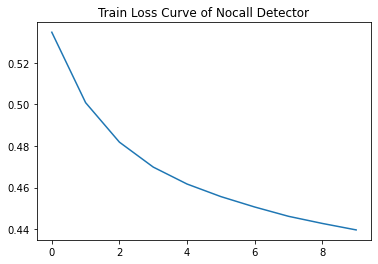

In [16]:
import matplotlib.pyplot as plt

train_losses = torch.tensor(train_losses, device = 'cpu')
plt.plot(np.arange(len(train_losses)), train_losses)
plt.title('Train Loss Curve of Nocall Detector')

C:\Users\youngrae\AppData\Local\Temp/ipykernel_2876/4126914523.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_losses = torch.tensor(val_losses, device = 'cpu')


Text(0.5, 1.0, 'Validation Accuracy Curve of Nocall Detector')

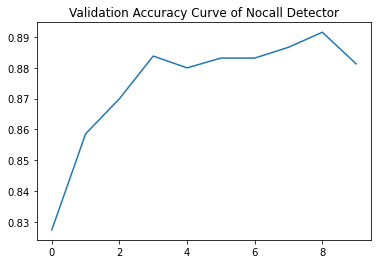

In [17]:
val_losses = torch.tensor(val_losses, device = 'cpu')
plt.plot(np.arange(len(val_losses)), val_losses)
plt.title('Validation Accuracy Curve of Nocall Detector')

C:\Users\youngrae\AppData\Local\Temp/ipykernel_2876/1290367574.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_scores = torch.tensor(log_scores, device = 'cpu')


Text(0.5, 1.0, 'Log-score Curve of Nocall Detector')

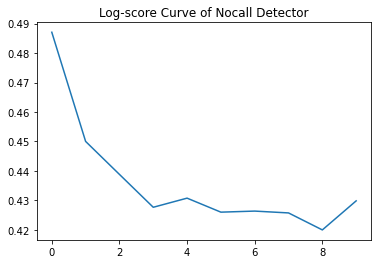

In [18]:
log_scores = torch.tensor(log_scores, device = 'cpu')
plt.plot(np.arange(len(log_scores)), log_scores)
plt.title('Log-score Curve of Nocall Detector')

C:\Users\youngrae\AppData\Local\Temp/ipykernel_2876/3035292173.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fbeta_scores = torch.tensor(fbeta_scores, device = 'cpu')


Text(0.5, 1.0, 'F-beta score Curve of Nocall Detector')

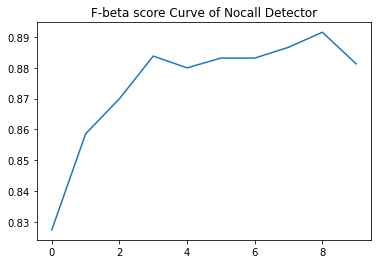

In [19]:
fbeta_scores = torch.tensor(fbeta_scores, device = 'cpu')
plt.plot(np.arange(len(fbeta_scores)), fbeta_scores)
plt.title('F-beta score Curve of Nocall Detector')

In [20]:
print('\nAccuracy: %.2f' % (100 * test_scores[0]))
print('Log Loss score:\t%.2f' % (test_scores[1]))
print('Fbeta-score (beta=1.0): \t%.2f' % (test_scores[2]))


Accuracy: 87.51
Log Loss score:	0.44
Fbeta-score (beta=1.0): 	0.88


In [21]:
torch.save(cur_model.state_dict(), './nocall_detector.pt')